<a href="https://www.kaggle.com/code/sadmansoumik/product-recommendation-based-on-visual-similarity?scriptVersionId=126561763" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Product Recommendation Based on Visual Similarity

The goal of this experiment is to create a basic recommender system that suggests products similar in appearance to a given fashion item. This type of recommender system is often used on shopping websites, appearing on product pages as a "you may also like" section. The system works on the premise that a customer showing interest in a particular product is likely to be interested in other items that are visually similar.

## Tutorial Content

We will use a pre-trained CNN model from Keras to extract image features. Then, we will calculate similarities between different products using the extracted image features. While other types of information, such as product category, size, and color, could be used to enhance the recommender system, this experiment will only focus on visual similarities.

## About Dataset
The dataset can be downloaded from this [Kaggle link](https://www.kaggle.com/datasets/olgabelitskaya/style-color-images). 
The main dataset (style.zip) is 2184 color images (150x150x3) with 7 brands and 10 products, and the file with labels style.csv.
Photo files are in the .png format and the labels are integers and values.

The file StyleColorImages.h5 consists of preprocessing images of this set: image tensors and targets (labels).

## Import All Required Dependencies

In [1]:
from keras.applications import resnet50
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input

from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

Using TensorFlow backend.


In [2]:
# Define dataset path
image_directory_path = "../input/style/"

# Set image dimensions for model
imgs_model_width = 224
imgs_model_height = 224

# Set the number of most similar images to retrieve
nb_closest_images = 5

## Load the ResNet50 pre-trained model from Keras

The Keras module contains several pre-trained models that can be easily loaded.For our recommender system based on visual similarity, we need to load a Convolutional Neural Network (CNN) that can interpret image contents.

In this example, we will load the ResNet50 model trained on ImageNet, a large labeled image database. If we take the whole model, we will get an output containing probabilities for certain classes, but that is not what we want. We want to retrieve all the information that the model was able to gather from the images. To do so, we have to remove the last layers of the CNN, which are **only used for predicting classes**. 

In [3]:
# Load the ResNet50 model with pre-trained weights on ImageNet
resnet50_model = resnet50.ResNet50(weights='imagenet')

# Create a feature extractor by removing the last layer of the ResNet50 model
# to get features instead of predictions
feature_extractor = Model(inputs=resnet50_model.input, outputs=resnet50_model.get_layer("avg_pool").output)

# Print a summary of the layers in the feature extractor CNN
feature_extractor.summary()

102858752/102853048 [==============================] - 2s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________

## Print the images paths

In [4]:
# Find all files in the directory with a .png extension
png_image_files = [image_directory_path + file_name for file_name in os.listdir(image_directory_path) if file_name.endswith(".png")]

# Output the total number of image files found
print("Total number of image files:", len(png_image_files))

Total number of image files: 2184


## Feed a single image into the CNN

First we observe what output we get when putting one image into the CNN.

The following steps are:
- loading the image
- preparing the image to feed it into the CNN
- get the CNN output which will correspond to the image features

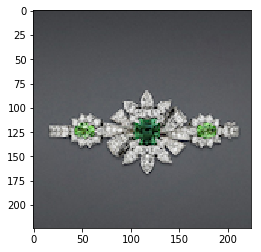

In [5]:
# Load an image in PIL format and display it
original = load_img(png_image_files[0], target_size=(imgs_model_width, imgs_model_height))
plt.imshow(original)
plt.show()

- Convert the PIL image to a numpy array
- In PIL - image is in (width, height, channel) format; but in Numpy - image is in (height, width, channel) format

In [6]:
numpy_image = img_to_array(original)

Convert the image / images into batch format. `expand_dims` will add an extra dimension to the data at a particular axis. We want the input matrix to the network to be of the form (batchsize, height, width, channels); thus we add the extra dimension to the axis 0.

In [7]:
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)

# prepare the image for the VGG model
processed_image = preprocess_input(image_batch.copy())

image batch size (1, 224, 224, 3)


In [8]:
# get the extracted features
img_features = feature_extractor.predict(processed_image)

print("Features successfully extracted!")
print("Number of image features:",img_features.size)
img_features

Features successfully extracted!
Number of image features: 2048


array([[0.11117435, 0.24934311, 0.94395477, ..., 1.4239305 , 0.        ,
        0.0401177 ]], dtype=float32)

## Feed all the images into the CNN

We were able to do the feature extraction process for one image. Now let's do it for all our images!

In [9]:
# load all the images and prepare them for feeding into the CNN

importedImages = []

for f in png_image_files:
    filename = f
    original = load_img(filename, target_size=(224, 224))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)
    
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [10]:
# extract the images features

imgs_features = feature_extractor.predict(processed_imgs)
print("Features successfully extracted!")
imgs_features.shape

Features successfully extracted!


(2184, 2048)

## Compute cosine similarities

Now that we have features for every image, we can compute similarity metrics between every image couple.We will use here the cosine similarity metric.

In [11]:
# compute cosine similarities between images
cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe
cos_similarities_df = pd.DataFrame(cosSimilarities, columns=png_image_files, index=png_image_files)
cos_similarities_df.head()

,../input/style/4_7_026.png,../input/style/5_0_037.png,../input/style/0_0_083.png,../input/style/6_7_006.png,../input/style/3_8_011.png,../input/style/6_3_003.png,../input/style/2_7_005.png,../input/style/0_2_027.png,../input/style/2_1_031.png,../input/style/4_5_017.png,../input/style/3_2_058.png,../input/style/4_5_026.png,../input/style/4_9_033.png,../input/style/4_2_037.png,../input/style/3_3_006.png,../input/style/3_7_007.png,../input/style/3_0_056.png,../input/style/2_1_016.png,../input/style/0_0_055.png,../input/style/4_2_067.png,../input/style/1_6_026.png,../input/style/4_8_003.png,../input/style/3_5_010.png,../input/style/4_9_039.png,../input/style/5_2_045.png,../input/style/6_3_038.png,../input/style/6_8_014.png,../input/style/4_6_017.png,../input/style/0_1_004.png,../input/style/3_6_014.png,../input/style/6_3_045.png,../input/style/0_3_002.png,../input/style/0_1_021.png,../input/style/4_1_036.png,../input/style/1_0_001.png,../input/style/2_2_060.png,../input/style/2_8_018.png,../input/style/1_1_005.png,../input/style/0_8_027.png,../input/style/5_4_014.png,...,../input/style/4_8_002.png,../input/style/2_2_009.png,../input/style/3_6_007.png,../input/style/3_4_006.png,../input/style/6_7_005.png,../input/style/2_0_065.png,../input/style/6_9_019.png,../input/style/3_9_019.png,../input/style/5_2_035.png,../input/style/5_2_001.png,../input/style/0_0_038.png,../input/style/2_0_025.png,../input/style/0_0_040.png,../input/style/2_2_034.png,../input/style/0_3_012.png,../input/style/0_2_025.png,../input/style/4_8_009.png,../input/style/6_2_012.png,../input/style/5_2_071.png,../input/style/3_0_036.png,../input/style/6_2_017.png,../input/style/1_0_030.png,../input/style/4_6_072.png,../input/style/5_6_020.png,../input/style/4_6_010.png,../input/style/6_0_050.png,../input/style/4_2_040.png,../input/style/6_7_018.png,../input/style/5_2_021.png,../input/style/0_0_087.png,../input/style/4_4_012.png,../input/style/1_1_018.png,../input/style/2_0_018.png,../input/style/6_3_020.png,../input/style/4_4_010.png,../input/style/0_2_014.png,../input/style/3_8_006.png,../input/style/2_2_008.png,../input/style/3_0_031.png,../input/style/1_2_013.png
../input/style/4_7_026.png,1.000000,0.290850,0.222810,0.222290,0.264802,0.273155,0.452224,0.327595,0.289923,0.288571,0.284471,0.316360,0.785010,0.272065,0.274972,0.331460,0.251233,0.277397,0.289169,0.278766,0.235641,0.250508,0.238150,0.670592,0.313645,0.195905,0.243637,0.498386,0.280438,0.257670,0.256634,0.233254,0.309452,0.294716,0.289221,0.308074,0.272906,0.192739,0.263861,0.244791,...,0.254392,0.275953,0.329185,0.345969,0.277367,0.394482,0.234973,0.661275,0.263853,0.473928,0.271550,0.296684,0.258031,0.410294,0.238643,0.254186,0.277136,0.211797,0.273675,0.263532,0.258559,0.226179,0.745837,0.327550,0.364663,0.238417,0.262888,0.388569,0.234369,0.267729,0.540223,0.239487,0.261473,0.239134,0.378263,0.294129,0.366185,0.255539,0.211661,0.479103
../input/style/5_0_037.png,0.290850,1.000000,0.439961,0.376166,0.557967,0.384454,0.353711,0.446039,0.370921,0.350397,0.497544,0.341991,0.255920,0.497016,0.437352,0.444723,0.519778,0.403904,0.531368,0.408440,0.369379,0.536360,0.502249,0.320214,0.400000,0.343196,0.505513,0.428819,0.372161,0.432876,0.409304,0.335184,0.379630,0.290335,0.659541,0.422010,0.497140,0.263658,0.486429,0.235458,...,0.525098,0.423217,0.599477,0.284351,0.652969,0.526607,0.378713,0.347662,0.443935,0.323406,0.610307,0.597244,0.529489,0.449745,0.350558,0.385181,0.540042,0.336828,0.400876,0.665581,0.353930,0.518779,0.342880,0.655826,0.392729,0.465150,0.377984,0.375597,0.462503,0.569276,0.207320,0.243587,0.645884,0.382171,0.298303,0.364415,0.503106,0.416791,0.570952,0.425831
../input/style/0_0_083.png,0.222810,0.439961,1.000000,0.240163,0.399681,0.380016,0.306338,0.328680,0.384518,0.300916,0.360364,0.409460,0.255412,0.423666,0.381630,0.312042,0.432232,0.311809,0.516173,0.325968,0.273922,0.452809,0.493624,0.265385,0.388239,0.362787,0.449142,0.303159,0.408413,0.356182,0.408094,0.323721,0.441196,0.342999,

## Retrieve most similar products

The final step is to implement a function that, for any given product, returns the visually most similar products.

In [12]:
# function to retrieve the most similar products for a given one
def retrieve_most_similar_products(given_img):

    print("-----------------------------------------------------------------------")
    print("original product:")

    original = load_img(given_img, target_size=(imgs_model_width, imgs_model_height))
    plt.imshow(original)
    plt.show()

    print("-----------------------------------------------------------------------")
    print("most similar products:")

    closest_imgs = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1].index
    closest_imgs_scores = cos_similarities_df[given_img].sort_values(ascending=False)[1:nb_closest_images+1]

    for i in range(0,len(closest_imgs)):
        original = load_img(closest_imgs[i], target_size=(imgs_model_width, imgs_model_height))
        plt.imshow(original)
        plt.show()
        print("similarity score : ",closest_imgs_scores[i])

-----------------------------------------------------------------------
original product:


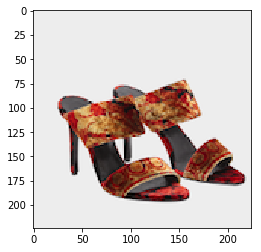

-----------------------------------------------------------------------
most similar products:


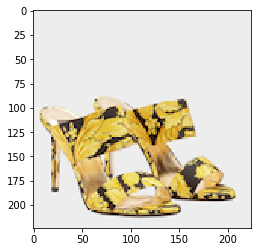

similarity score :  0.7321974


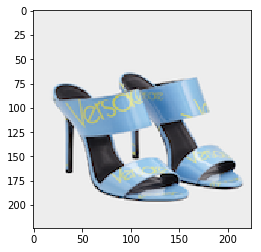

similarity score :  0.7306763


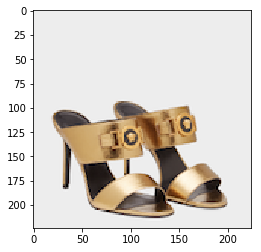

similarity score :  0.720398


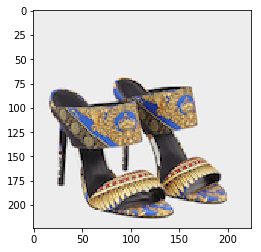

similarity score :  0.7159919


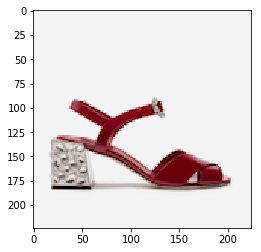

similarity score :  0.7155856


In [13]:
retrieve_most_similar_products(png_image_files[1])

-----------------------------------------------------------------------
original product:


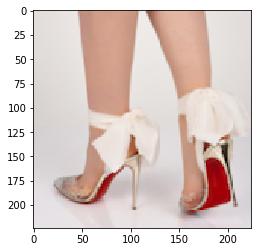

-----------------------------------------------------------------------
most similar products:


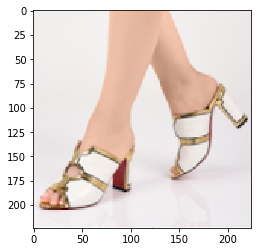

similarity score :  0.8215814


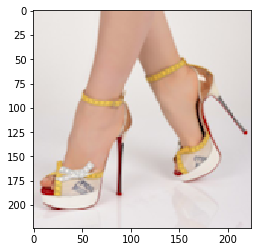

similarity score :  0.79710597


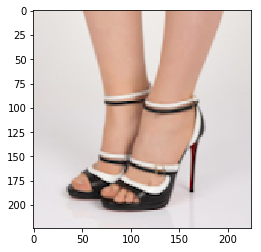

similarity score :  0.7942452


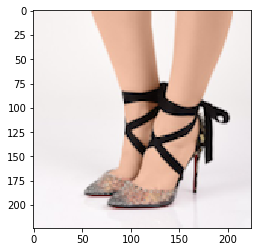

similarity score :  0.7756468


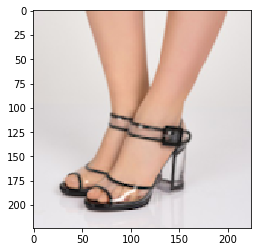

similarity score :  0.7728104


In [14]:
retrieve_most_similar_products(png_image_files[2])

-----------------------------------------------------------------------
original product:


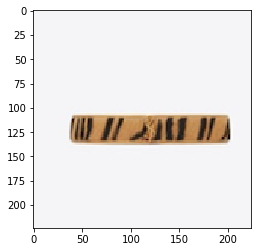

-----------------------------------------------------------------------
most similar products:


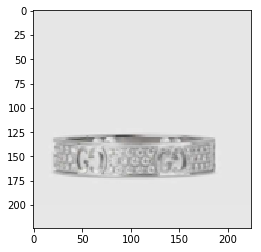

similarity score :  0.61081505


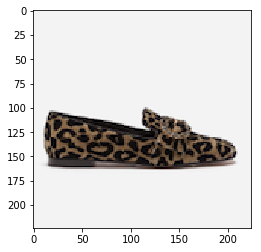

similarity score :  0.5880844


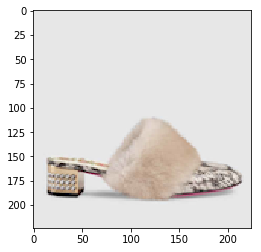

similarity score :  0.5839091


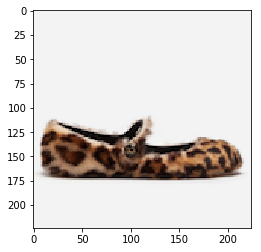

similarity score :  0.5835045


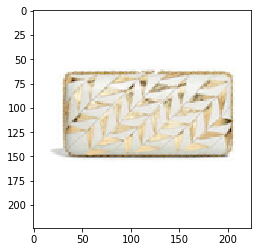

similarity score :  0.58003926


In [15]:
retrieve_most_similar_products(png_image_files[3])

-----------------------------------------------------------------------
original product:


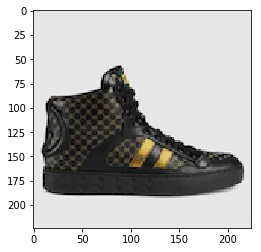

-----------------------------------------------------------------------
most similar products:


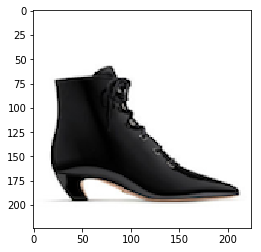

similarity score :  0.82089573


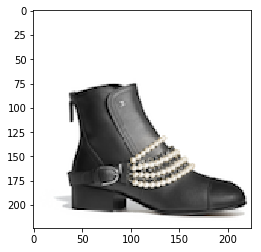

similarity score :  0.79972535


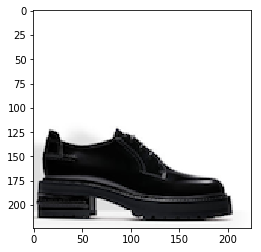

similarity score :  0.7922876


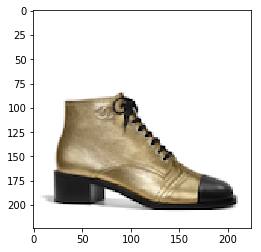

similarity score :  0.7883318


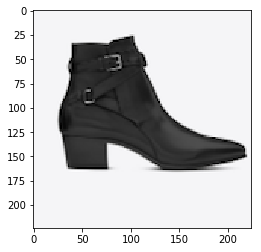

similarity score :  0.7872446


In [16]:
retrieve_most_similar_products(png_image_files[4])

-----------------------------------------------------------------------
original product:


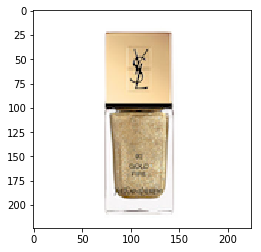

-----------------------------------------------------------------------
most similar products:


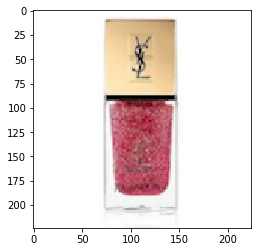

similarity score :  0.82945406


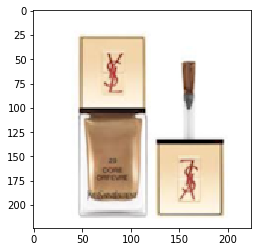

similarity score :  0.8180965


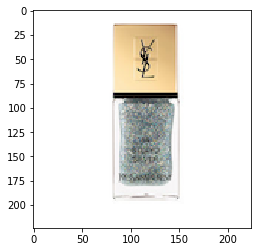

similarity score :  0.8159808


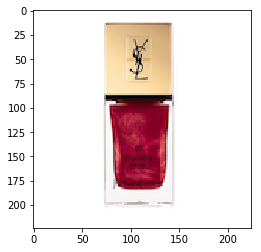

similarity score :  0.80476755


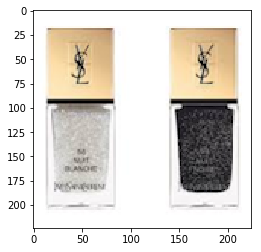

similarity score :  0.803878


In [17]:
retrieve_most_similar_products(png_image_files[5])